# Exploring NLP with HuggingFace Transformers

**🤗 Transformers is ["On a mission to solve NLP, one commit at a time"](https://huggingface.co/), so I figured I would make a notebook to explore their library to demonstrate how powerful it is. In this notebook, I use BERT to classify texts that are about natural disastors. I have another notebook where I use a GPT-2 with HuggingFace to generate text, which you can find [here](https://www.kaggle.com/tuckerarrants/text-generation-with-huggingface-gpt2)**

In [1]:
# copied from https://www.kaggle.com/tuckerarrants/bert-with-huggingface-transformers
#the basics
import os, re, math, string, pandas as pd, numpy as np, seaborn as sns

#graphing
import matplotlib.pyplot as plt

#deep learning
import tensorflow as tf

#nlp
from wordcloud import STOPWORDS

#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

**Tweak here for quick notebook changes:**

In [2]:
#choose batch size
BATCH_SIZE = 16

#how many epochs?
EPOCHS = 2

#clean Tweets?
CLEAN_TWEETS = False

#use meta data?
USE_META = True

#add dense layer?
ADD_DENSE = False
DENSE_DIM = 64

#add dropout?
ADD_DROPOUT = True
DROPOUT = .2

#train BERT base model? 
TRAIN_BASE = True

In [3]:
#get data
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

#peek at train
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

# 0. Preprocessing

**We will add this section to experiment with text processing and how cleaning text affects our model's performance. However, these mdoels were originally trained without preprocessing to learn the context of as many kinds of sentences as possible, so carrying out standard NLP text cleaning could actually hurt our model's performance**

In [5]:
#a handy set indeed
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))

#define function to expand contractions and showcase
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [6]:
#this stips tweet related characters
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

#check functionality
strip_all_entities('@shawn Titanic #tragedy could have been prevented Economic Times: Telegraph.co.uk Titanic tragedy could have been prevented... http://bet.ly/tuN2wx')

'Titanic tragedy could have been prevented Economic Times Telegraph co uk Titanic tragedy could have been prevented'

In [7]:
#this removes stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in STOPWORDS])

In [8]:
#apply to Tweets
if CLEAN_TWEETS:
    for df in [train, test]:
        df['text'] = df['text'].apply(expand_contractions)
        df['text'] = df['text'].apply(strip_all_entities)
        df['text'] = df['text'].apply(remove_stopwords)

# I. Meta Features

**We can also include meta-features to feed to our BERT model to see if it improves performance:**

In [9]:
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

In [10]:
for df in [train, test]:
    df['word count'] = df['text'].apply(lambda x: len(x.split()))
    df['character count'] = df['text'].apply(lambda x: len(x))
    df['average word length'] = df['text'].apply(average_word_length)
    df['unique word count'] = df['text'].apply(lambda x: len(set(x.split())))
    df['stopword count'] = df['text'].apply(lambda x: len([i for i in x.lower().split() if i in STOPWORDS]))
    #df['punctuation count'] = df['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))
    df['stopword ratio'] = df['stopword count'] / df['word count']
    df['url count'] = df['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

In [11]:
meta_train = StandardScaler().fit_transform(train.iloc[:, 2:])
meta_test = StandardScaler().fit_transform(test.iloc[:, 1:])

#meta_train = MinMaxScaler().fit_transform(train.iloc[:, 2:])
#meta_test = MinMaxScaler().fit_transform(test.iloc[:, 1:])

# II. Different Tokenizers

**We can quickly explore how the different transformer models in HuggingFace tokenize text:**

In [12]:
#BERT
from transformers import BertTokenizer
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.



Encode: [101, 4372, 16044, 2033, 999, 102]
Decode: [CLS] encode me! [SEP]


In [13]:
#RoBERTa
from transformers import RobertaTokenizer
TOKENIZER = RobertaTokenizer.from_pretrained("roberta-base")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))


Encode: [0, 2271, 20414, 162, 328, 2]
Decode: <s> Encode me!</s>


In [14]:
#AlBERTa
from transformers import AlbertTokenizer
TOKENIZER = AlbertTokenizer.from_pretrained("albert-base-v1")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))


Encode: [2, 20523, 55, 187, 3]
Decode: [CLS] encode me![SEP]


In [15]:
#BART
from transformers import BartTokenizer
TOKENIZER = BartTokenizer.from_pretrained('facebook/bart-large')
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))


Encode: [0, 2271, 20414, 162, 328, 2]
Decode: <s> Encode me!</s>


In [16]:
#ELECTRA and BERT have identical tokenizers
from transformers import BertTokenizer
TOKENIZER = BertTokenizer.from_pretrained('google/electra-base-generator')
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))


Encode: [101, 4372, 16044, 2033, 999, 102]
Decode: [CLS] encode me! [SEP]


# III. BERT

## 1. Base

**Here we will use the TensorFlow BERT base model, which you can read more about [here](https://huggingface.co/bert-base-uncased). You can also implement these transformers with PyTorch just as easily:**

In [17]:
import tensorflow as tf
from transformers import TFBertModel, BertModel

In [18]:
#get BERT layer
bert_base = TFBertModel.from_pretrained('bert-base-uncased')
#bert_base = BertModel.from_pretrained('bert-base-uncased')          #to use with PyTorch

#select BERT tokenizer
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")

In [19]:
def bert_encode(data,maximum_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = TOKENIZER.encode_plus(data.text[i],
                                        add_special_tokens=True,
                                        max_length=maximum_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [20]:
def build_model(model_layer, learning_rate, use_meta = USE_META, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    meta_input = tf.keras.Input(shape = (meta_train.shape[1], ))
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    output = transformer_layer[1]
    
    #add meta data
    if use_meta:
        output = tf.keras.layers.Concatenate()([output, meta_input])
    
    #add dense relu layer
    if add_dense:
        print("Training with additional dense layer...")
        output = tf.keras.layers.Dense(dense_dim,activation='relu')(output)
    
    #add dropout
    if add_dropout:
        print("Training with dropout...")
        output = tf.keras.layers.Dropout(dropout)(output)
    
    #add final node for binary classification
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    #assemble and compile
    if use_meta:
        print("Training with meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks, meta_input],outputs = output)
    
    else:
        print("Training without meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'], color = '#171820')
    ax[0].plot(history.history['val_accuracy'], color = '#fdc029')

    ax[1].plot(history.history['loss'], color='#171820')
    ax[1].plot(history.history['val_loss'], color = '#fdc029')

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Learning Curves", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [22]:
if TRAIN_BASE:
    #get our inputs
    print('Encoding Tweets...')
    train_input_ids,train_attention_masks = bert_encode(train,60)
    test_input_ids,test_attention_masks = bert_encode(test,60)
    print('Tweets encoded')
    print('')

    #debugging step
    print('Train length:', len(train_input_ids))
    print('Test length:', len(test_input_ids))

Encoding Tweets...
Tweets encoded

Train length: 7613
Test length: 3263


In [23]:
#and build and view parameters
BERT_base = build_model(bert_base, learning_rate = 1e-5)
BERT_base.summary()

Training with dropout...
Training with meta-data...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 60, 768), (N 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 7)

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('base_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [25]:
#train BERT
if TRAIN_BASE:
    if USE_META:
        history = BERT_base.fit([train_input_ids,train_attention_masks, meta_train], train.target, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
    
    else:
        history = BERT_base.fit([train_input_ids,train_attention_masks], train.target, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)   

Epoch 1/2
381/381 [==============================] - 65s 170ms/step - loss: 0.4554 - accuracy: 0.7995 - val_loss: 0.3839 - val_accuracy: 0.8319
Epoch 2/2
381/381 [==============================] - 61s 160ms/step - loss: 0.3524 - accuracy: 0.8589 - val_loss: 0.3879 - val_accuracy: 0.8332


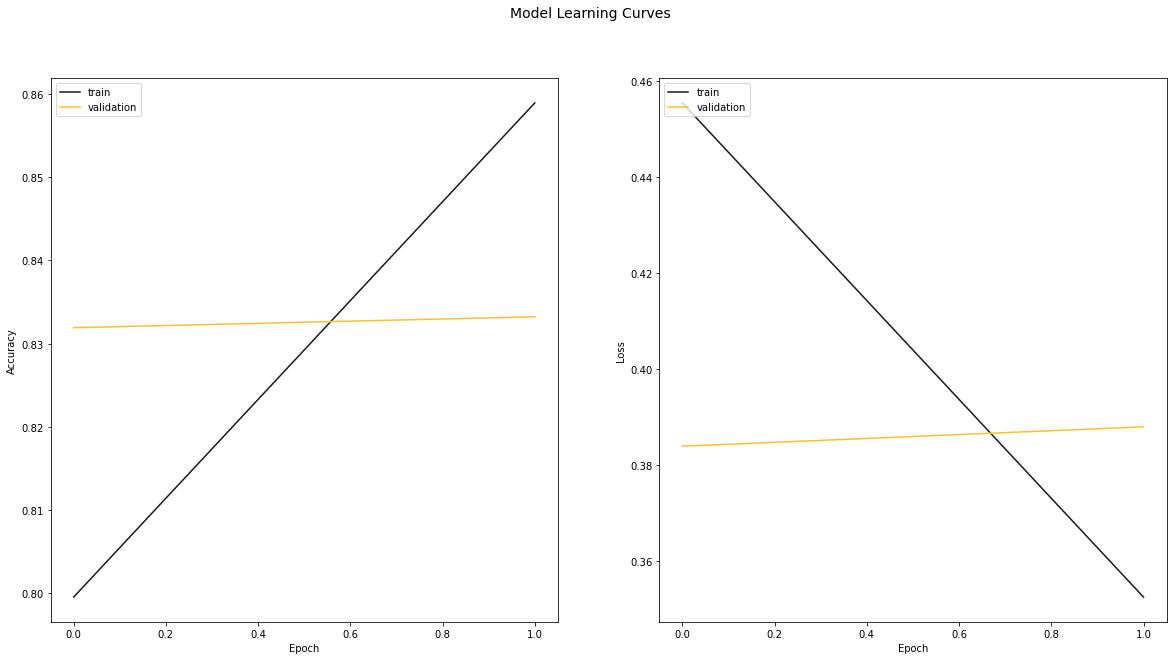

In [26]:
if TRAIN_BASE:
    plot_learning_curves(history)

In [27]:
#load model with best losses
if TRAIN_BASE:
    BERT_base.load_weights('base_model.h5') 

In [28]:
#predict with BERT
if TRAIN_BASE:
    if USE_META:
        preds_base = BERT_base.predict([test_input_ids,test_attention_masks,meta_test])

    else:
        preds_base = BERT_base.predict([test_input_ids,test_attention_masks])

In [29]:
#save as dataframe
if TRAIN_BASE:
    submission_base = pd.DataFrame()
    submission_base['id'] = test_id
    submission_base['prob'] = preds_base
    submission_base['target'] = np.round(submission_base['prob']).astype(int)
    submission_base.head(10)

In [30]:
if TRAIN_BASE:
    submission_base = submission_base[['id', 'target']]

    #save to disk
    submission_base.to_csv('submission_bert_base.csv', index = False)
    print('Submission saved')

Submission saved


## 2. Large

**Just a beefier version of BERT; you can read more about it [here](https://huggingface.co/bert-large-uncased)**

In [31]:
#get BERT layer
bert_large = TFBertModel.from_pretrained('bert-large-uncased')
#bert_base = BertModel.from_pretrained('bert-large-uncased')          #to use with PyTorch

#select BERT tokenizer
TOKENIZER = BertTokenizer.from_pretrained("bert-large-uncased")

#get our inputs
train_input_ids,train_attention_masks = bert_encode(train,60)
test_input_ids,test_attention_masks = bert_encode(test,60)

#debugging step
print('Train length:', len(train_input_ids))
print('Test length:', len(test_input_ids))

#and build and view parameters
BERT_large = build_model(bert_large, learning_rate = 1e-5)
BERT_large.summary()


Train length: 7613
Test length: 3263
Training with dropout...
Training with meta-data...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 60, 1024), ( 335141888   input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
in

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('large_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [33]:
#train BERT
if USE_META:
    history = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train.target, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
    
else:
    history = BERT_large.fit([train_input_ids,train_attention_masks], train.target, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)

Epoch 1/2
381/381 [==============================] - 184s 482ms/step - loss: 0.4727 - accuracy: 0.7931 - val_loss: 0.3831 - val_accuracy: 0.8464
Epoch 2/2
381/381 [==============================] - 174s 458ms/step - loss: 0.3657 - accuracy: 0.8540 - val_loss: 0.3992 - val_accuracy: 0.8391


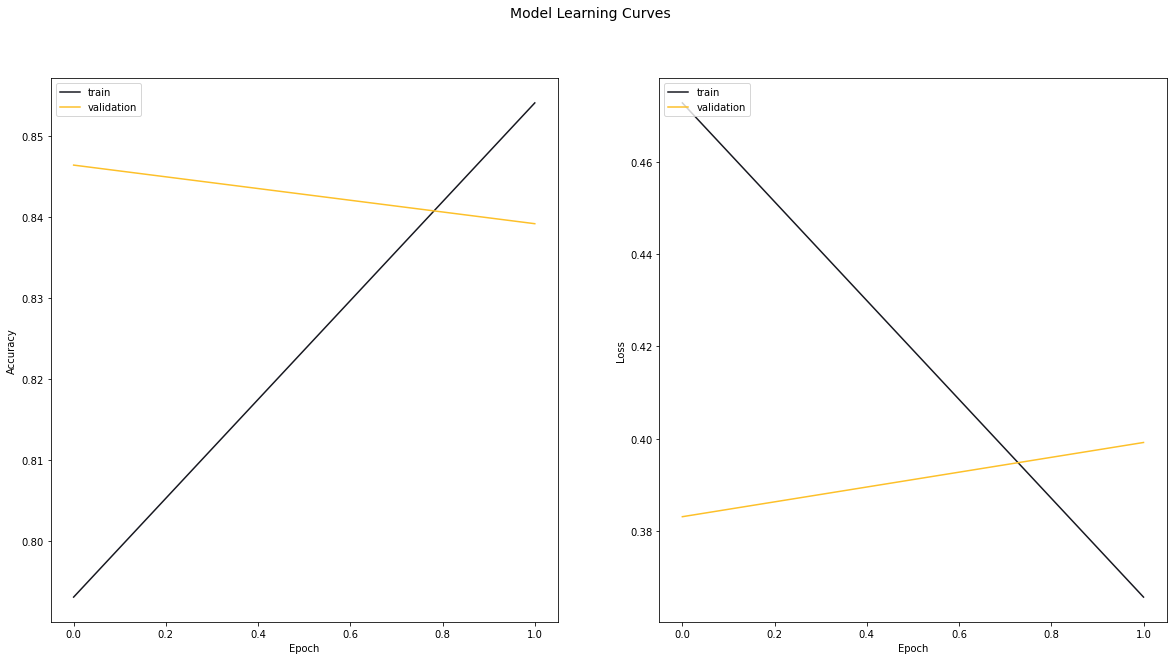

In [34]:
plot_learning_curves(history)

In [35]:
#load model with best losses
BERT_large.load_weights('large_model.h5') 

In [36]:
#predict with BERT
if USE_META:
    preds_large = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

else:
    preds_large = BERT_large.predict([test_input_ids,test_attention_masks])  

In [37]:
#save as dataframe
submission_large = pd.DataFrame()
submission_large['id'] = test_id
submission_large['prob'] = preds_large
submission_large['target'] = np.round(submission_large['prob']).astype(int)
submission_large.head(10)

,id,prob,target
0,0,0.941671,1
1,2,0.955918,1
2,3,0.965982,1
3,9,0.957996,1
4,11,0.968516,1
5,12,0.890438,1
6,21,0.104163,0
7,22,0.068748,0
8,27,0.070108,0
9,29,0.054668,0


In [38]:
submission_large = submission_large[['id', 'target']]

#save to disk
submission_large.to_csv('submission_bert_large.csv', index = False)
print('Submission saved')

Submission saved


# IV. Final Submission

**Here we can experiment with blending the predictions of different transformer models with different weights if we want to, but seeing as the BERT base and large are similarly structured, blending their predictions probably won't benefit us too much:**

In [39]:
#create blended submission
submission_final = pd.DataFrame()
submission_final['id'] = test_id
if TRAIN_BASE:
    submission_final['base prob'] = preds_base
submission_final['large prob'] = preds_large
#submission_final['blended prob'] = .5 * preds_base + .5 * preds_large
submission_final.head(10)

,id,base prob,large prob
0,0,0.918959,0.941671
1,2,0.954491,0.955918
2,3,0.929378,0.965982
3,9,0.981858,0.957996
4,11,0.975776,0.968516
5,12,0.889078,0.890438
6,21,0.079617,0.104163
7,22,0.065635,0.068748
8,27,0.059037,0.070108
9,29,0.060531,0.054668
